>import packages and set up SparkSession

In [31]:
import multiprocessing
import pyspark
import os
import datetime
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import setuptools #required for df.toPandas() in Python 3.12

In [2]:
cfg = (
    pyspark.SparkConf()
        # Setting the master to run locally and with the maximum amount of cpu coresfor multiprocessing.
        .setMaster(f"local[{multiprocessing.cpu_count()}]")            
        # Setting application name
        .setAppName("TestApp")
        # Setting config value via string
        .set("spark.eventLog.enabled", False)
        # Setting memory if this setting was not set previously
        .setIfMissing("spark.executor.memory", "1g")
)

session = pyspark.sql.SparkSession.builder.config(conf=cfg).getOrCreate()
sc = session.sparkContext

>Ingest data from .csv file

In [3]:
df = session.read.option("header", True).csv("LEGO_Data/sets.csv")

>Get rolling average of piece count by year and plot on a graph

In [85]:
timeRange = 5 #set time range for rolling average in years

W = Window().orderBy(df.Year.cast('int')).rangeBetween(-timeRange+1,0)
dfRA = df.withColumn('roll', F.avg("Pieces").over(W)) \
    .select('Year', F.round('roll',2).alias('Rolling_AVG')) \
    .distinct()

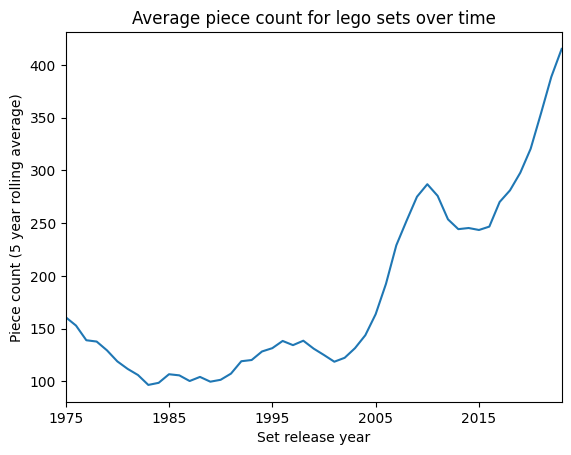

In [86]:
xMin = int(dfRA.agg({"Year": "min"}).collect()[0][0])
xMax = int(df.agg({"Year": "max"}).collect()[0][0])
ax = dfRA.toPandas().plot(kind='line',x='Year',y='Rolling_AVG', legend=None, \
                    xlabel='Set release year', \
                    ylabel=f'Piece count ({timeRange} year rolling average)', \
                    title='Average piece count for lego sets over time', \
                    xlim=(0,xMax-xMin))